In [284]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
)

from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import (
    RadiusNeighborsClassifier,
    NeighborhoodComponentsAnalysis,
    KNeighborsClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

data = {
    "model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "train_score": [],
    "test_score": [],
}
models = pd.DataFrame(columns=data)

pd.options.display.max_columns = None
titanic = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/train.csv"
)
test = pd.read_csv(
    r"/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/test.csv"
)
ids = test["PassengerId"]

combine = [titanic, test]

    pclass : Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

    sibsp	# of siblings / spouses aboard the Titanic

    parch	# of parents / children aboard the Titanic

    ticket	Ticket number

    fare	Passenger fare

    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


# EDA


In [285]:
titanic.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [286]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [287]:
titanic.isna().sum() * 100 / len(titanic)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: Drop Cabin column, since it has  77 % missing data</b><br>
        <b>Insight: Drop name, PassengerId and Ticket columns, since this columns is not important</b><br>
    </span>    
</div>


31.871345029239766
68.12865497076024


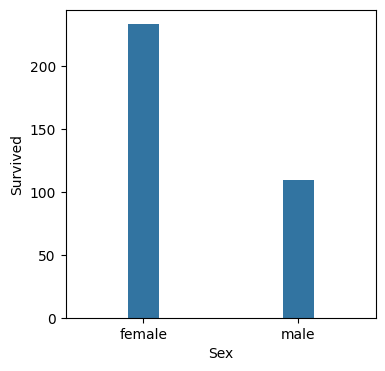

In [288]:
print(
    len(titanic[(titanic["Sex"] == "male") & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Sex"] == "female") & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

plt.figure(figsize=(4, 4))

data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Sex", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: as a prediction, females have a much higher chance of survival than males</b><br>
    </span>    
</div>


39.76608187134503
25.43859649122807
34.7953216374269


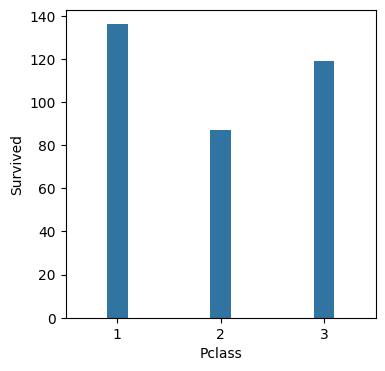

In [289]:
print(
    len(titanic[(titanic["Pclass"] == 1) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Pclass"] == 2) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

print(
    len(titanic[(titanic["Pclass"] == 3) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)


plt.figure(figsize=(4, 4))
data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Pclass", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: the class is not effected sinece people in 3rd class and Survived more the  in 2rd class</b><br>
    </span>    
</div>


0  : 61.40350877192982
1  : 32.748538011695906
2  : 3.801169590643275
3  : 1.1695906432748537
4  : 0.8771929824561403


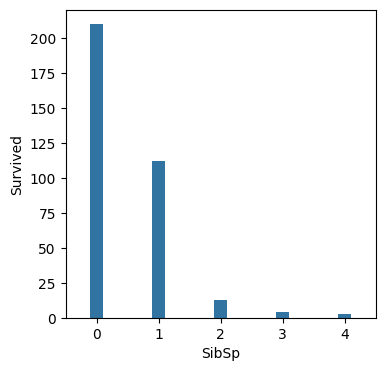

In [290]:
data = titanic[titanic["Survived"] == 1]

arr = data["SibSp"].unique()
arr = list(arr)
arr.sort()
for val in arr:
    print(val, " :", len(data[(data["SibSp"] == val)]) * 100 / len(data))

plt.figure(figsize=(4, 4))
sns.barplot(data=data, x="SibSp", y="Survived", width=0.2, estimator="sum")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Insight: as a prediction, when you have less number of siblings or spouses, you will have a much higher chance of survival</b><br>
    </span>    
</div>


<Axes: xlabel='Age', ylabel='Survived'>

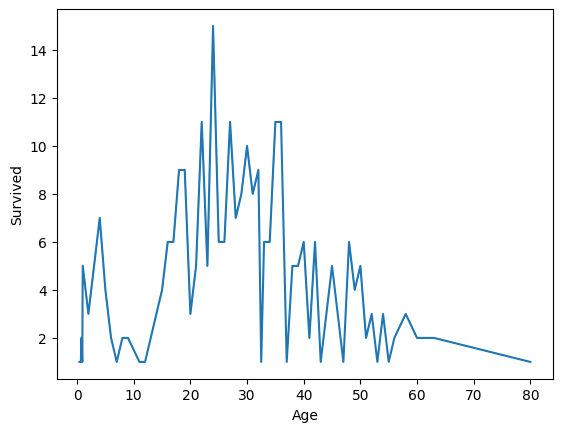

In [291]:
data = titanic[titanic["Survived"] == 1]

sns.lineplot(data=data, x="Age", y="Survived", estimator="sum")

# Cleaning


In [292]:
titanic = titanic.drop(["Ticket", "Cabin"], axis=1)
test = test.drop(["Ticket", "Cabin"], axis=1)

combine = [titanic, test]

for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)

### Missing values and edidting columns


In [293]:
mapper = {"female": 0, "male": 1}

for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map(mapper)
    dataset["Age"] = dataset["Age"].fillna(int(dataset["Age"].mean()))
    dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].mode()[0])
    dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].mean())

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,S,Mr


### Constructing new columns


In [294]:
mapper = {"Mr": 1, "Mrs": 2, "Miss": 3, "Master": 4, "Rare": 5}


def ubdate_age(age):
    if age <= 16:
        return 0
    if age <= 32:
        return 1
    if age <= 48:
        return 2
    if age <= 65:
        return 3
    if age <= 85:
        return 4


def ubdate_fare(fare):
    if fare <= 7.9:
        return 0
    if fare <= 14.5:
        return 1
    if fare <= 31:
        return 2
    return 3


def ubdate_Embarked(Embarked):
    if Embarked == "C":
        return 0
    if Embarked == "Q":
        return 1
    if Embarked == "S":
        return 2


def alone_or_not(family_sz):
    if family_sz == 1:
        return 1
    return 0


for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )

    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    dataset["Title"] = dataset["Title"].map(mapper)

    dataset["Age"] = dataset["Age"].apply(ubdate_age)

    dataset["Fare"] = dataset["Age"].apply(ubdate_fare)

    dataset["Family size"] = dataset["SibSp"] + dataset["Parch"] + 1

    dataset["Is Alone"] = dataset["Family size"].apply(alone_or_not)

    dataset["Embarked"] = dataset["Embarked"].apply(ubdate_Embarked)

    dataset["Age*calss"] = dataset["Age"] * dataset["Pclass"]

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family size,Is Alone,Age*calss
0,892,3,"Kelly, Mr. James",1,2,0,0,0,1,1,1,1,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,0,2,2,2,0,6
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,0,1,1,1,1,6
3,895,3,"Wirz, Mr. Albert",1,1,0,0,0,2,1,1,1,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,0,2,2,3,0,3


In [295]:
titanic = titanic.drop(["Name", "PassengerId", "Parch", "SibSp", "Family size"], axis=1)
test = test.drop(["Name", "Parch", "SibSp", "Family size"], axis=1)
combine = [titanic, test]

In [296]:
titanic.isna().sum(), test.isna().sum()

(Survived     0
 Pclass       0
 Sex          0
 Age          0
 Fare         0
 Embarked     0
 Title        0
 Is Alone     0
 Age*calss    0
 dtype: int64,
 PassengerId    0
 Pclass         0
 Sex            0
 Age            0
 Fare           0
 Embarked       0
 Title          0
 Is Alone       0
 Age*calss      0
 dtype: int64)

In [297]:
titanic.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Is Alone,Age*calss
0,0,3,1,1,0,2,1,0,3
1,1,1,0,2,0,0,2,0,2
2,1,3,0,1,0,2,3,1,3
3,1,1,0,2,0,2,2,0,2
4,0,3,1,2,0,2,1,1,6


# Spliting data


In [298]:
x_train, x_test, y_train, y_test = train_test_split(
    titanic.drop(columns="Survived", axis="columns"),
    titanic["Survived"],
    random_state=34,
    test_size=0.3,
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(623, 8)
(623,)
(268, 8)
(268,)


# Models

- Logistic Regression
- k-Nearest Neighbors
- R-Nearest Neighbors
- Decision Tree Classifier
- Random Forest Classifier


## 1) LogisticRegression


In [299]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X=x_train, y=y_train)

train_score = log_reg.score(x_train, y_train)
test_score = log_reg.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.7897271268057785
train score =  0.7985074626865671


In [300]:
log_reg_prediction = log_reg.predict(x_test)
MAE = mean_absolute_error(y_pred=log_reg_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=log_reg_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.20149253731343283, 0.20149253731343283, 0.4488792012484348)

In [301]:
data = {
    "model": "LogisticRegression",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507


In [302]:
y_p = cross_val_predict(log_reg, x_test, y_test, cv=20)

accuracy_score(y_test, y_p)

0.7947761194029851

## 2) k-Nearest Neighbors


In [303]:
num_neighbors = int(np.sqrt(len(x_train)))

neighbors = [num_neighbors]
for i in range(9):
    neighbors.append(num_neighbors + i + 1)
for i in range(9):
    neighbors.append(num_neighbors - (i + 1))

KNC_models = []
Cross_valdation = []

for k in neighbors:
    KNC = KNeighborsClassifier(n_neighbors=k, algorithm="ball_tree")
    KNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(KNC, X=x_train, y=y_train, cv=4)
    KNC_models.append(KNC)
    Cross_valdation.append([k, np.mean(valdation), np.std(valdation)])

train_score = [KNC_.score(x_train, y_train) for KNC_ in KNC_models]
test_score = [KNC_.score(x_test, y_test) for KNC_ in KNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["K-neighbors", "mean_acc", "std"]
)

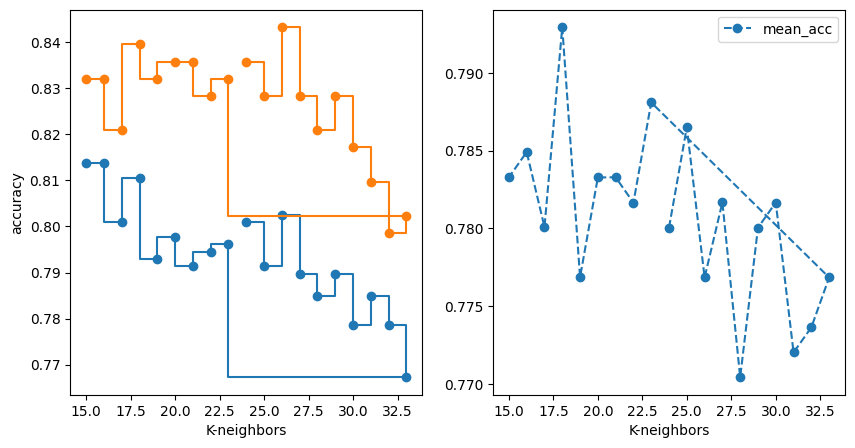

In [304]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("K-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(neighbors, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(neighbors, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="K-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### By the cross val score, when the data set changed the model becomes unstabel, more formally this model is not good


### BEST K is 26, with about .80 score for traing and 0.84 score for testing


In [305]:
KNC = KNeighborsClassifier(n_neighbors=26, algorithm="ball_tree")
KNC.fit(X=x_train, y=y_train)
train_score = KNC.score(x_train, y_train)
test_score = KNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.8025682182985554
train score =  0.8432835820895522


In [306]:
KNC_prediction = KNC.predict(x_test)
MAE = mean_absolute_error(y_pred=KNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=KNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.15671641791044777, 0.15671641791044777, 0.39587424507089086)

In [307]:
data = {
    "model": "KNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507
1,KNeighborsClassifier,0.156716,0.156716,0.395874,0.802568,0.843284


## 3) R-Nearest Neighbors


In [308]:
R = 50

Raduisies = [R]
for i in range(20):
    Raduisies.append(R + i + 0.5)

for i in range(20):
    Raduisies.append(R - (i + 0.5))

RNC_models = []
Cross_valdation = []

for r in Raduisies:
    RNC = RadiusNeighborsClassifier(radius=r, algorithm="ball_tree")
    RNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(RNC, X=x_train, y=y_train, cv=4)
    RNC_models.append(RNC)
    Cross_valdation.append([r, np.mean(valdation), np.std(valdation)])

train_score = [RNC_.score(x_train, y_train) for RNC_ in RNC_models]
test_score = [RNC_.score(x_test, y_test) for RNC_ in RNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["R-neighbors", "mean_acc", "std"]
)

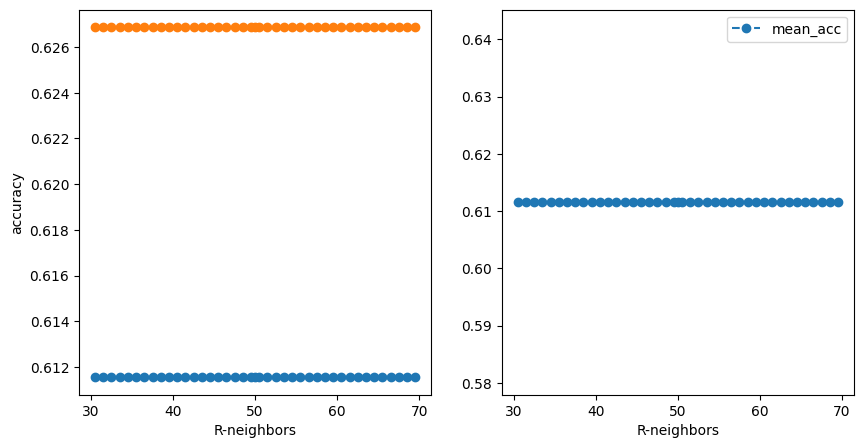

In [309]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("R-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(Raduisies, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(Raduisies, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="R-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### I think it is a bad decision to choose RadiusNeighborsClassifier model 🤣🤣🤣


### How ever, i will choose 40.5 as a raduis


In [310]:
RNC = RadiusNeighborsClassifier(radius=40.5, algorithm="ball_tree")
RNC.fit(X=x_train, y=y_train)
train_score = RNC.score(x_train, y_train)
test_score = RNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.6115569823434992
train score =  0.6268656716417911


In [311]:
RNC_prediction = RNC.predict(x_test)
MAE = mean_absolute_error(y_pred=RNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.373134328358209, 0.373134328358209, 0.6108472217815262)

In [312]:
data = {
    "model": "RadiusNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507
1,KNeighborsClassifier,0.156716,0.156716,0.395874,0.802568,0.843284
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866


## 4) Decision Tree Classifier


In [313]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

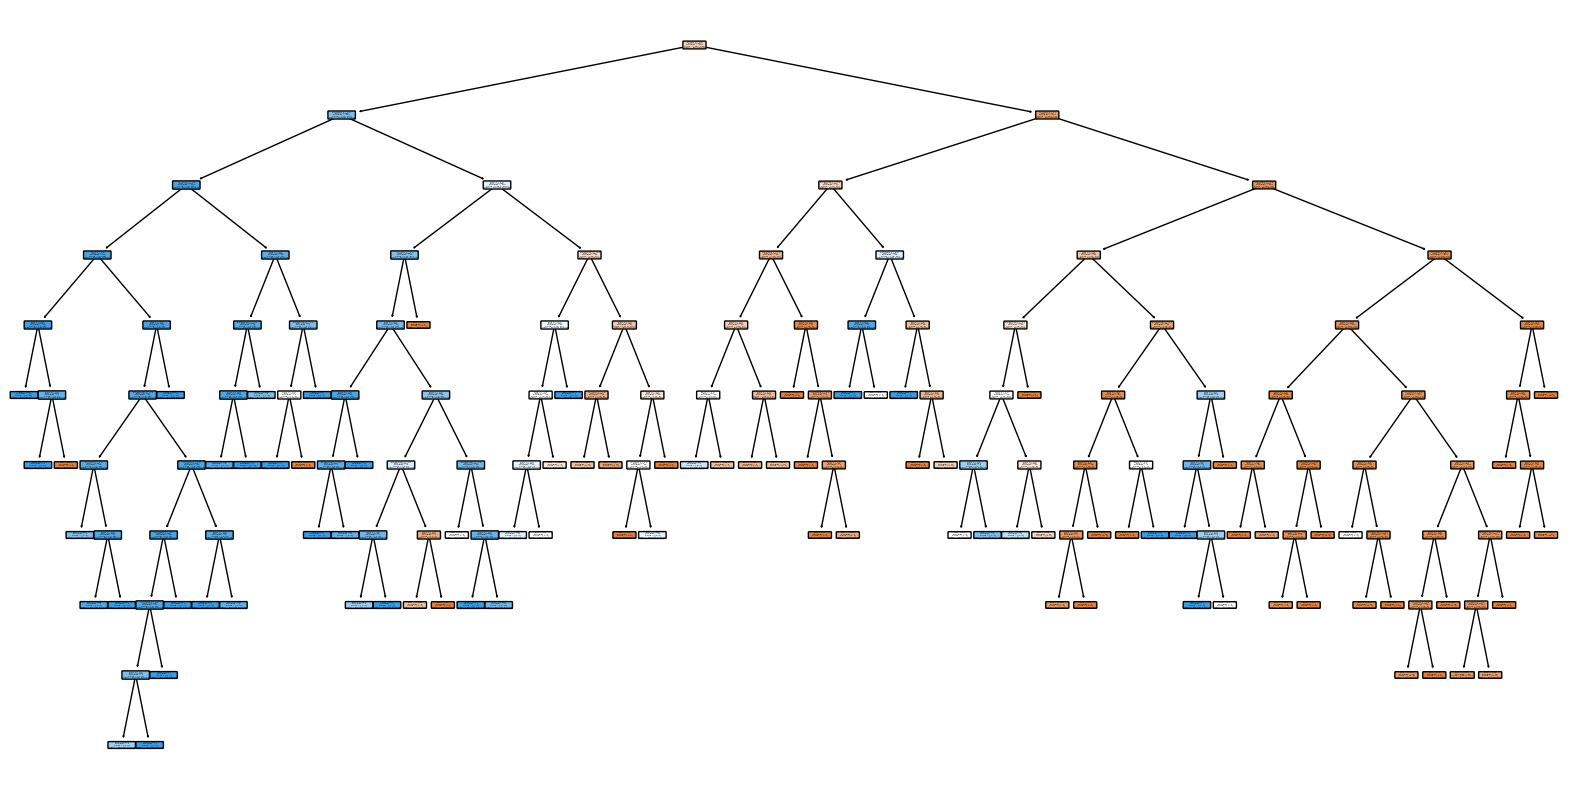

In [314]:
plt.figure(figsize=(20, 10))
plot_tree(
    DTC,
    class_names=["will Survive", "will not Survive"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### I think this tree over fit the model


In [315]:
print(DTC.score(x_train, y_train))
print(DTC.score(x_test, y_test))

0.8459069020866774
0.8171641791044776


### as I expected, there is an overfit probelm, let's fix it by pruning the tree


In [316]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]
DTC_models = []

Cross_valdation = []

for alpha in alphas:
    DTC = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    DTC.fit(x_train, y_train)
    score = cross_val_score(DTC, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    DTC_models.append(DTC)


train_score = [DTC_.score(x_train, y_train) for DTC_ in DTC_models]
test_score = [DTC_.score(x_test, y_test) for DTC_ in DTC_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

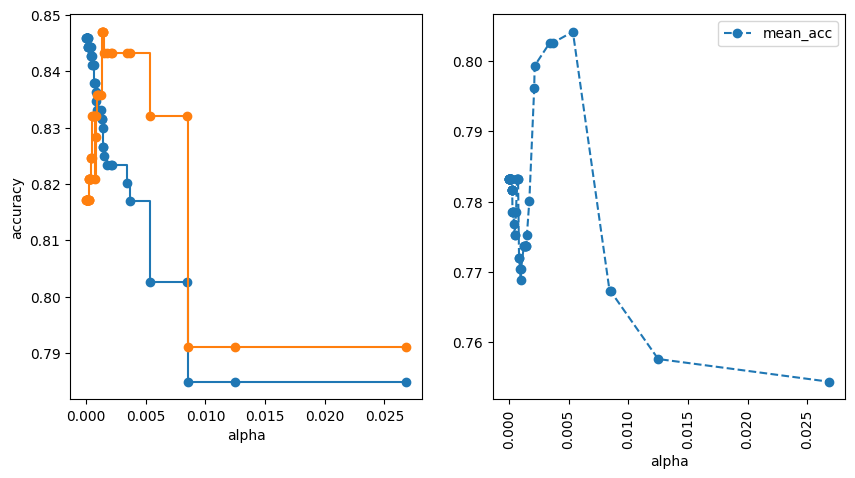

In [317]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [318]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.005) & (alpha_results["alpha"] > 0.001)
]["alpha"]

alpha

43    0.001022
44    0.001251
45    0.001293
46    0.001313
47    0.001373
48    0.001445
49    0.001453
50    0.001511
51    0.001712
52    0.002121
53    0.002159
54    0.003420
55    0.003673
Name: alpha, dtype: float64

In [319]:
DTC_pruned = DecisionTreeClassifier(ccp_alpha=0.001453, random_state=42)
DTC_pruned.fit(x_train, y_train)
train_score = DTC_pruned.score(x_train, y_train)
test_score = DTC_pruned.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.826645264847512
test score =  0.8470149253731343


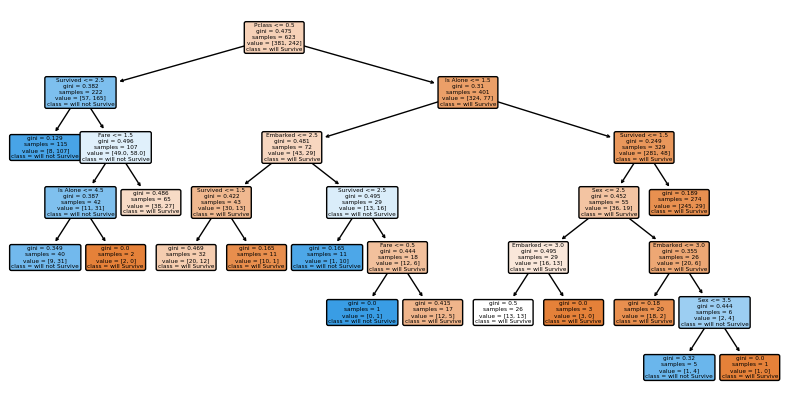

In [320]:
plt.figure(figsize=(10, 5))
plot_tree(
    DTC_pruned,
    class_names=["will Survive", "will not Survive"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### Great work


In [321]:
DTC_pruned_prediction = DTC_pruned.predict(x_test)
MAE = mean_absolute_error(y_pred=DTC_pruned_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=DTC_pruned_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.15298507462686567, 0.15298507462686567, 0.39113306511578083)

In [322]:
data = {
    "model": "DecisionTreeClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507
1,KNeighborsClassifier,0.156716,0.156716,0.395874,0.802568,0.843284
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866
3,DecisionTreeClassifier,0.152985,0.152985,0.391133,0.826645,0.847015


# 5) Random Forest


In [323]:
RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=0.002408)
RF.fit(X=x_train, y=y_train)
RF.score(X=x_train, y=y_train), RF.score(X=x_test, y=y_test)

(0.8282504012841091, 0.8395522388059702)

In [324]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]

RF_models = []

Cross_valdation = []

for alpha in alphas:
    RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=alpha)
    RF.fit(x_train, y_train)
    score = cross_val_score(RF, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    RF_models.append(RF)


train_score = [RF_.score(x_train, y_train) for RF_ in RF_models]
test_score = [RF_.score(x_test, y_test) for RF_ in RF_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

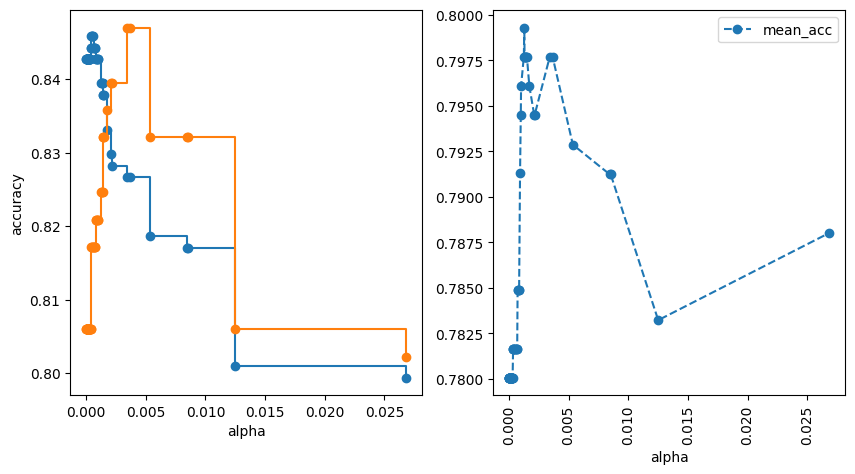

In [325]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [326]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.005) & (alpha_results["alpha"] >= 0.002)
]["alpha"]

alpha

52    0.002121
53    0.002159
54    0.003420
55    0.003673
Name: alpha, dtype: float64

In [327]:
RF = RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=0.003673)
RF.fit(X=x_train, y=y_train)
train_score = RF.score(x_train, y_train)
test_score = RF.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.826645264847512
test score =  0.8470149253731343


In [328]:
RF_prediction = RF.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.15298507462686567, 0.15298507462686567, 0.39113306511578083)

In [329]:
data = {
    "model": "RandomForestClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507
1,KNeighborsClassifier,0.156716,0.156716,0.395874,0.802568,0.843284
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866
3,DecisionTreeClassifier,0.152985,0.152985,0.391133,0.826645,0.847015
4,RandomForestClassifier,0.152985,0.152985,0.391133,0.826645,0.847015


# Votting


In [356]:
estimators = [
    (
        "KNC",
        KNeighborsClassifier(n_neighbors=23, algorithm="ball_tree"),
    ),
    (
        "DTC_purned",
        DecisionTreeClassifier(ccp_alpha=0.001713, random_state=42),
    ),
    (
        "RF",
        RandomForestClassifier(n_estimators=20, random_state=42, ccp_alpha=00.002573),
    ),
]

wghts = [
    KNC.score(x_train, y_train),
    DTC.score(x_train, y_train),
    RF.score(x_train, y_train),
]

vot = VotingClassifier(estimators=estimators, voting="soft", weights=wghts)
vot

VotingClassifier(estimators=[('KNC',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   n_neighbors=23)),
                             ('DTC_purned',
                              DecisionTreeClassifier(ccp_alpha=0.001713,
                                                     random_state=42)),
                             ('RF',
                              RandomForestClassifier(ccp_alpha=0.002573,
                                                     n_estimators=20,
                                                     random_state=42))],
                 voting='soft',
                 weights=[0.8025682182985554, 0.7849117174959872,
                          0.826645264847512])

In [357]:
vot.fit(x_train, y_train)
train_score = vot.score(x_train, y_train)
test_score = vot.score(x_test, y_test)

print("train score = ", train_score)
print("test score = ", test_score)

train score =  0.8250401284109149
test score =  0.8470149253731343


In [332]:
vot_prediction = vot.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.15298507462686567, 0.15298507462686567, 0.39113306511578083)

In [333]:
data = {
    "model": "VotingClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507
1,KNeighborsClassifier,0.156716,0.156716,0.395874,0.802568,0.843284
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866
3,DecisionTreeClassifier,0.152985,0.152985,0.391133,0.826645,0.847015
4,RandomForestClassifier,0.152985,0.152985,0.391133,0.826645,0.847015
5,VotingClassifier,0.152985,0.152985,0.391133,0.826645,0.850746


In [334]:
models.sort_values(by=["test_score"], ascending=[False])

,model,MAE,MSE,RMSE,train_score,test_score
5,VotingClassifier,0.152985,0.152985,0.391133,0.826645,0.850746
3,DecisionTreeClassifier,0.152985,0.152985,0.391133,0.826645,0.847015
4,RandomForestClassifier,0.152985,0.152985,0.391133,0.826645,0.847015
1,KNeighborsClassifier,0.156716,0.156716,0.395874,0.802568,0.843284
0,LogisticRegression,0.201493,0.201493,0.448879,0.789727,0.798507
2,RadiusNeighborsClassifier,0.373134,0.373134,0.610847,0.611557,0.626866


In [355]:
predictions = vot.predict(test.drop("PassengerId", axis="columns"))

submmition = pd.DataFrame({"PassengerId": ids, "Survived": predictions})
submmition.to_csv(
    "/home/ahmed/Ai/Kaggle-Competitions-Notebooks/Titanic/DataStes/submission.csv",
    index=False,
)

# The END
